# Predicting future demand

The predict cycle takes as input the model generated in the [data analysis](./data-analysis.ipynb) stage. 

Using the transition rates and new entry rates as well as a starting population, the model iterates day-by-day to see how the population changes over time. 

We start off by calculating our population statistics:

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
from cs_demand_model import Config, DemandModellingDataContainer, ModelPredictor, PopulationStats, fs_datastore

config = Config()
datastore = fs_datastore("sample://v1.zip")
dc = DemandModellingDataContainer(datastore, config)
stats = PopulationStats(dc.enriched_view, config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


From this we can now run a model prediction to see how the population evolves. 
As we covered in the data analysis documentation, we need to provide a start and end date for the analysis window.

In [2]:
start_date, end_date = pd.to_datetime('2019-07-01'), pd.to_datetime('2020-01-01')
predictor = ModelPredictor.from_model(stats, start_date, end_date)

The predictor is an iterative model that has a state and can return the predictor for the next period. 

To see the current population, in this case the starting population from the model, view the `initial_population`:

In [3]:
predictor.initial_population

age_bin     placement_type
Birth to 1  Foster              0.0
            Other               0.0
1 to 5      Foster              0.0
            Other               0.0
5 to 10     Foster             23.0
            Resi                3.0
            Other               0.0
10 to 16    Foster            130.0
            Resi               31.0
            Other              23.0
16 to 18+   Foster              9.0
            Resi                1.0
            Supported          14.0
            Other               7.0
Name: 2020-01-01 00:00:00, dtype: float64

We can now ask for the next population:

In [4]:
predictor = predictor.next()
predictor.initial_population

age_bin     placement_type
Birth to 1  Foster              0.000000
            Other               0.000000
            Resi                0.000000
            Supported           0.000000
1 to 5      Foster              0.000000
            Other               0.000000
            Resi                0.000000
            Supported           0.000000
5 to 10     Foster             22.968340
            Other               0.000000
            Resi                2.994304
            Supported           0.000000
10 to 16    Foster            129.690642
            Other              22.947726
            Resi               30.931805
            Supported           0.000000
16 to 18+   Foster              9.039045
            Other               6.990565
            Resi                1.008479
            Supported          13.949464
Name: 2020-01-02 00:00:00, dtype: float64

You can run the above block multiple times to see the population change. To reset, go back and create a new predictor from the initial state. 

Since we usually want to run multiple iterations in one simple operations, there is also a utility method on the predictor to run *n* generations and return a dataframe of all the populations. You can add progress=True to get a progress bar so you have something to enjoy watching while you make a cup of tea...

In [36]:
predictor = ModelPredictor.from_model(stats, start_date, end_date)
predicted_pop = predictor.predict(720, progress=True)  # Predict 720 days forward
predicted_pop.groupby(level=1, axis=1).sum()

2021-12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:19<00:00, 36.23it/s]


placement_type,Foster,Other,Resi,Supported
2020-01-02,161.698027,29.938290,34.934588,13.949464
2020-01-03,161.396678,29.876702,34.869258,13.899110
2020-01-04,161.095950,29.815236,34.804012,13.848937
2020-01-05,160.795842,29.753891,34.738849,13.798946
2020-01-06,160.496354,29.692667,34.673769,13.749136
...,...,...,...,...
2021-12-17,48.790459,6.630264,8.003926,1.051066
2021-12-18,48.721015,6.616037,7.986829,1.047272
2021-12-19,48.651712,6.601840,7.969768,1.043491
2021-12-20,48.582550,6.587673,7.952743,1.039725


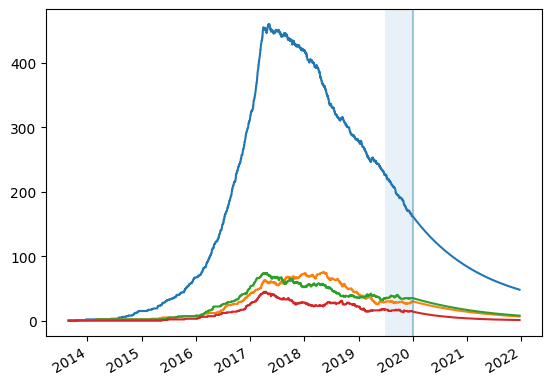

In [34]:
historic_pop = stats.stock.loc[:end_date]
combined_pop = pd.concat([historic_pop, predicted_pop], axis=0)

# Remove this to see individual sequences
combined_pop = combined_pop.groupby(level=1, axis=1).sum()

combined_pop.plot(legend=False)
pp.axvline(end_date, alpha=0.4)
pp.axvspan(start_date, end_date, alpha=0.1)
pp.show()

In [35]:
predictor = ModelPredictor.from_model(stats, start_date, end_date)
predicted_pop = predictor.predict(72, step_days=10, progress=True)  # Predict 720 days forward
predicted_pop.groupby(level=1, axis=1).sum()

2021-12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 34.49it/s]


placement_type,Foster,Other,Resi,Supported
2020-01-11,158.980070,29.382442,34.341309,13.495478
2020-01-21,156.022478,28.777112,33.691356,13.009137
2020-01-31,153.125928,28.183784,33.050263,12.540323
2020-02-10,150.289152,27.602233,32.418133,12.088404
2020-02-20,147.510908,27.032240,31.795048,11.652771
...,...,...,...,...
2021-11-11,50.929782,7.066765,8.522432,1.154048
2021-11-21,50.192312,6.915428,8.340853,1.112459
2021-12-01,49.469860,6.767271,8.163094,1.072369
2021-12-11,48.762114,6.622229,7.989078,1.033724


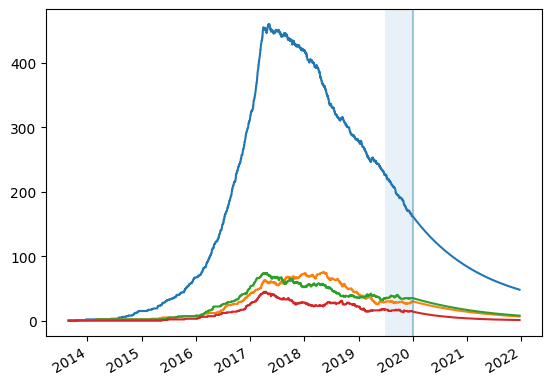

In [33]:
historic_pop = stats.stock.loc[:end_date]
combined_pop = pd.concat([historic_pop, predicted_pop], axis=0)

# Remove this to see individual sequences
combined_pop = combined_pop.groupby(level=1, axis=1).sum()

combined_pop.plot(legend=False)
pp.axvline(end_date, alpha=0.4)
pp.axvspan(start_date, end_date, alpha=0.1)
pp.show()